In [34]:
import numpy as np
import os
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from tensorflow.keras.layers import Input, LSTM, Dense, Bidirectional, Activation
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras.utils import plot_model, to_categorical
# from tensorflow.keras.preprocessing import 

In [2]:
pwd = os.getcwd()
database_path = pwd[:-6] + "flightData/filtered_data/scenario5"

In [3]:
database_file_names = []
for root, dirs, files in os.walk(database_path):
    database_file_names = [os.path.join(root,file) for file in files]
#     print(database_file_names)

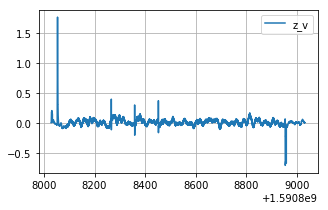

In [4]:
plt.figure(figsize=(5,3))
# for i,file in enumerate(database_file_names):
file = database_file_names[0]
data = pd.read_csv(file)
# i=1
col = data.columns[13]
# for col in data.columns:
#     if col=='time':
#         continue
x = data['time'].values
y = data[col].values
#     plt.subplot(7,2,i)
plt.plot(x,y,label=col)
plt.grid()
plt.legend()
#     i=i+1
    #     data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
    #     data.to_csv(file,index=False)
#     old_label = pd.unique(data['label'])
#     print(old_label)
#     new_label = [j for j in range(1,len(old_label)+1)]
#     data = data.replace(old_label, new_label)
#     #     print(file)
#     x = data['x'].values
#     y = data['y'].values
#     t = data['time'].values
#     label = data['label'].values
# #     label[22800:25350] = 4
#     label = label*10
#     plt.subplot(25,2,i+1)
#     #     plt.plot(t,x)
#     indx = 0
#     plt.plot(y[indx:])
#     plt.plot(label[indx:])
#     plt.grid()
#     file_name = file.split("/")
#     file_name = file_name[-1]
#     plt.title(file_name)

# newfile = file[:-4]+'_new.csv'
# data = data.replace(new_label, old_label)
# data.to_csv(newfile, index=False)

#     print(i)

In [5]:
data.head()

,label,pitch,pitch_v,roll,roll_v,time,x,x_v,y,y_v,yaw,yaw_v,z,z_v
0,Hold,-0.0,0.0,0.0,0.0,1.590808e+09,-0.000006,-0.000833,-0.000001,-0.000181,0.0,0.0,0.000001,0.000533
1,Hold,-0.0,0.0,0.0,0.0,1.590808e+09,-0.000006,-0.000833,-0.000001,-0.000181,0.0,0.0,0.000001,0.000533
2,Hold,-0.0,0.0,0.0,0.0,1.590808e+09,-0.000032,-0.000283,-0.000026,-0.000761,0.0,0.0,0.000140,0.005525
3,Hold,-0.0,0.0,0.0,0.0,1.590808e+09,-0.000032,-0.000283,-0.000026,-0.000761,0.0,0.0,0.000140,0.005525
4,Hold,-0.0,0.0,0.0,0.0,1.590808e+09,-0.000032,-0.000283,-0.000026,-0.000761,0.0,0.0,0.000140,0.005525


In [14]:
print([i for i in range(1,len(pd.unique(data['label']))+1)])

[1, 2, 3, 4, 5, 6]


In [20]:
print(pd.unique(data['label']))

[1 2 3 4 5 6]


In [34]:
print(file[:-4]+'_new.csv')

/Users/mrinmoysarkar/Documents/git_repos/ros-intel-uav-rpeo/simulation_ws/src/pie/flightData/filtered_data/scenario4/scenario4_9_new.csv


In [92]:
X_train = data.drop(columns=['label', 'time'])
X_train = X_train.values
print(X_train.shape)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
Y_train = data['label'].values
Y_train = Y_train.reshape((-1,1))
encoder = OneHotEncoder()
Y_train = encoder.fit_transform(Y_train).toarray()
print(Y_train.shape)
print(Y_train[0,:])

(59902, 12)
(59902, 7)
[1. 0. 0. 0. 0. 0. 0.]


In [95]:
def batch_gen(X,y,time_step,batch_size=64):
    i = 0
    m = X.shape[0]
    while True:
        x_batch = []
        y_batch = []
        for j in range(batch_size):
            if i+j+time_step == m:
                i = -1
                break
            x_batch.append(X[i+j:i+j+time_step,:])
            y_batch.append(y[i+j+time_step,:])
        i=i+1
        yield (np.array(x_batch), np.array(y_batch))
        


In [96]:
# X = [[1,6],[2,7],[3,8],[4,9],[5,10]]
# Y = [[1,6],[2,7],[3,8],[4,9],[5,10]]
# X = np.array(X)
# Y = np.array(Y)
# print(X.shape)
# print(Y.shape)
i=0
for (x,y) in batch_gen(X_train,Y_train,10,32):
    i=i+1
    print(x.shape)
    print(y.shape)
    if i>5:
        break

(32, 10, 12)
(32, 7)
(32, 10, 12)
(32, 7)
(32, 10, 12)
(32, 7)
(32, 10, 12)
(32, 7)
(32, 10, 12)
(32, 7)
(32, 10, 12)
(32, 7)


In [97]:
#create model
num_feature = 12
time_step = 8
num_class = 7
x_in = Input(shape=(time_step,num_feature),dtype="float32")
forward_layer = LSTM(units=20, return_sequences=True, activation='tanh')
backward_layer = LSTM(units=20, return_sequences=True, activation='tanh', go_backwards=True)
bid_layer = Bidirectional(layer=forward_layer,backward_layer=backward_layer, merge_mode='concat')(x_in)
y = Dense(units=num_class,activation='softmax')(bid_layer[:,-1,:])
model = Model(inputs=x_in,outputs=y)
optimizer = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
loss = losses.categorical_crossentropy
model.compile(optimizer=optimizer, loss=loss, metrics=[metrics.Accuracy()])

In [98]:
print(model.summary())

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 8, 12)]           0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 8, 40)             5280      
_________________________________________________________________
tf_op_layer_strided_slice_3  [(None, 40)]              0         
_________________________________________________________________
dense_8 (Dense)              (None, 7)                 287       
Total params: 5,567
Trainable params: 5,567
Non-trainable params: 0
_________________________________________________________________
None


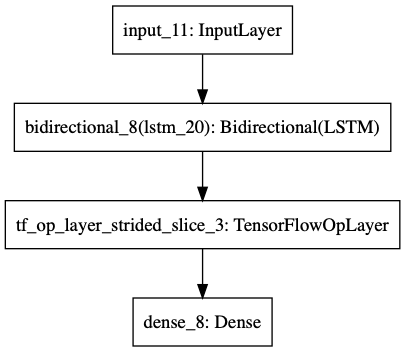

In [99]:
plot_model(model=model,to_file="model.png")

In [ ]:
history = model.fit(batch_gen(X_train,Y_train,time_step,batch_size=32), epochs=100, verbose=2, shuffle=False)

  ...
    to  
  ['...']
Epoch 1/100
